## Forecasting Retail Turnover

In this notebook I attempt to find a forecasting model for the Quarterly Retail Turnover time series data set.  We set out to find which model will perform best.


The models that will be compared are the ARIMA model, Exponential Smoothing Model, and a Regression-based Model.  In order to find which model is best among the three, we can set aside a portion of the last observations as a holdout sample and fit our model to the rest of the observations.  Whichever model best captures the autocorrelation in the errors, passes the white noise test, and gives the most accurate predictions for our holdout sample will be our best model.


### Data 

The data used in this project comes from [here.]( https://datamarket.com/data/set/22n7/quarterly-retail-turnover-m-current-jun-1982-dec-1991#!ds=22n7&display=line
)


In [25]:
title 'Retail Turnover from 1982 to 1992';
ods noproctitle;
ods graphics on;
options validvarname=v7;
%let path = /folders/myfolders/sasuser.v94/quarterly-retail-turnover.csv;

proc import datafile="&path" dbms=csv out=retail replace;
run;

proc print data=retail;
run;

Obs,Quarter,Quarterly_Retail_Turnover
1,1982Q3,13423.2
2,1982Q4,13128.8
3,1983Q1,15398.8
4,1983Q2,12964.2
5,1983Q3,13133.5
6,1983Q4,13271.7
7,1984Q1,15596.3
8,1984Q2,13018
9,1984Q3,13409.3
10,1984Q4,13304.2


The dataset has 39 observations, so we can hold back the last 12 observations as our holdout sample when performing model estimation.  Just a quick note, the RetailTurnover.ipynb here is a symbolic link pointing to a file in a shared folder being used with VirtualBox (I'm using SAS University Edition).  That's why the path here seems off.  I did this so I could keep all of my data analysis notebooks in a single repository.


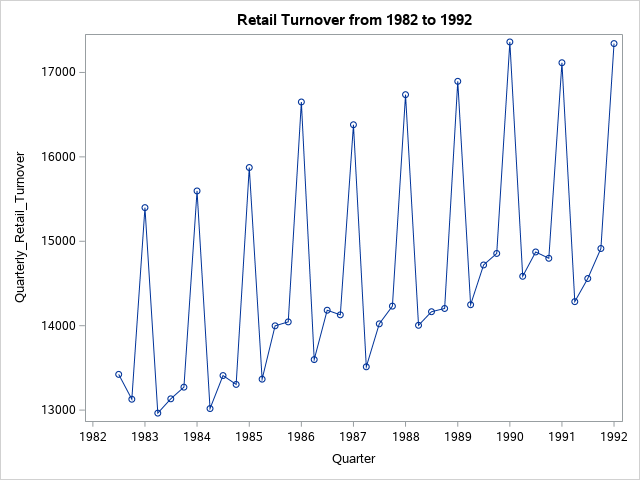

In [26]:
proc sgplot data=retail;
    series x=quarter y=quarterly_retail_turnover /markers;
run;

Here we just plot the data to see if there’s anything that stands out.  One of the first things we notice is that the turnover seems to fluctuate around an average that increases in a linear fashion over time.  This suggests that we should include a linear trend component.  We can also see seasonal variation which means we should incorporate 3 seasonal dummy variables for the 4 quarters.


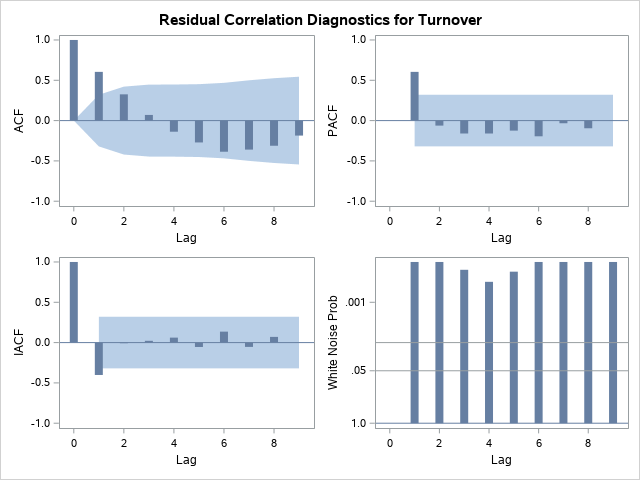
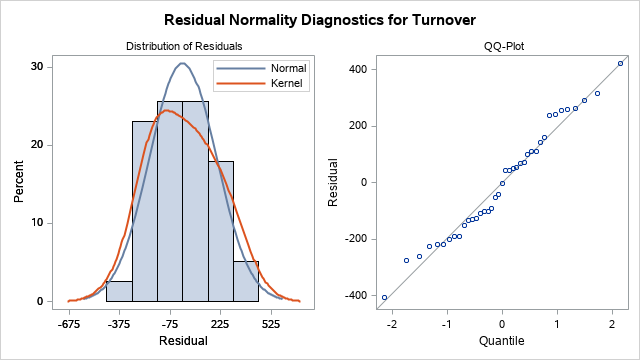
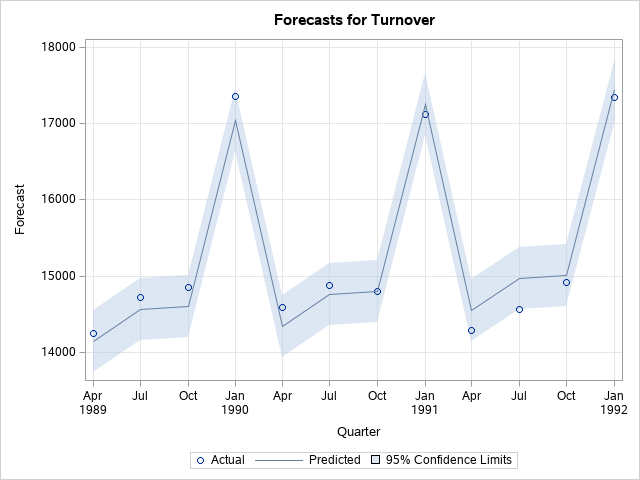

In [27]:
data retail;
    set retail;
    if qtr(Quarter)=1 then
        do;
            Q1=1;
            Q2=0;
            Q3=0;
        end;
    else if qtr(Quarter)=2 then
        do;
            Q1=0;
            Q2=1;
            Q3=0;
        end;
    else if qtr(Quarter)=3 then
        do;
            Q1=0;
            Q2=0;
            Q3=1;
        end;
    else
        do;
            Q1=0;
            Q2=0;
            Q3=0;
        end;
    rename Quarterly_Retail_Turnover=Turnover;
run;

title2 "Regression Model (Attempt 1)";
%let arima_display = ParameterEstimates ChiSqAuto ResidualNormalityPanel ResidualCorrPanel ForecastsOnlyPlot;

proc arima data=retail;
    identify var=Turnover crosscorr=(Quarter Q1 Q2 Q3);
    estimate input=(Quarter Q1 Q2 Q3);
    forecast lead=12 back=12 id=Quarter interval=qtr out=forecast0;
    ods select &arima_display;
    ods show;
run;

%macro rmse(dataset);
    proc sql;
        select sqrt(MSE) as RMSE
        from (
              select (SSE/12) as MSE
              from (
                    select SUM(RESIDUAL*RESIDUAL) as SSE
                    from &dataset(firstobs=28 obs=39)
                    )
               )
    run;
%mend rmse;

%rmse(forecast0);

Determining whether or not an independent variable is significant through hypothesis testing has already been discussed in detail in the previous project, so I won't go over it again here.  Looking at our output shows that our intercept, linear trend, Q1, and Q2 variables are all significant.  The only coefficient that isn't significant is Q3 but that needs to stay in our model if we choose to use seasonal components.


The sample autocorrelation plot (ACF) measures the linear relationship between the time series residuals separated by a lagged time unit (in this case quarters).  A value close to 1 signifies positive autocorrelation (followed by value with same sign) while a value close to -1 signifies negative autocorrelation (followed by value with negative sign).  The sample partial autocorrelation plot (PACF) is similar to the ACF plot.  It is the autocorrelation of observations separated a lagged time unit after removing the effects from terms at shorter/more recent lags.  In sample ACF and PACF plots we can see a significant spike and then cutoff at lag 1 which suggests significant autocorrelation with lag 1. 


The plots are also useful in helping us determining the behavior of the ACF/PACF.  If the plot shows the autocorrelation dying or cutting off quickly, then we can consider the time series to stationary.  If the plot shows autocorrelation dying off slowly then the plot can be considered stationary.  This plot also shows the manner in how the autocorrelation dies down (exponential, sine-wave like or alternating).  All of this is useful when building an ideal ARIMA forecasting model (ACF for determining moving average parameter, PACF for determining autoregressive parameter).  


The white noise probability plot measures the significance probabilities of the residuals that we use for hypothesis testing.  Our hypothesis test can be written as follows:

  * $H_0:$ Residuals are white noise (no autocorrelation)
  * $H_a:$ Residuals aren't white noise (autocorrelation present)


Since the white noise probability bars are all tall (p-value smaller then $\alpha$=0.5 and 0.1) we reject the null hypothesis in favor of the alternative hypothesis and determine that this model is inadequate.  We can try to capture the errors by including an AR(1).  The ARIMA procedure in SAS allows us to obtain point estimates for our intercept and independent variables as well as model the error terms with a first-order autoregressive process.



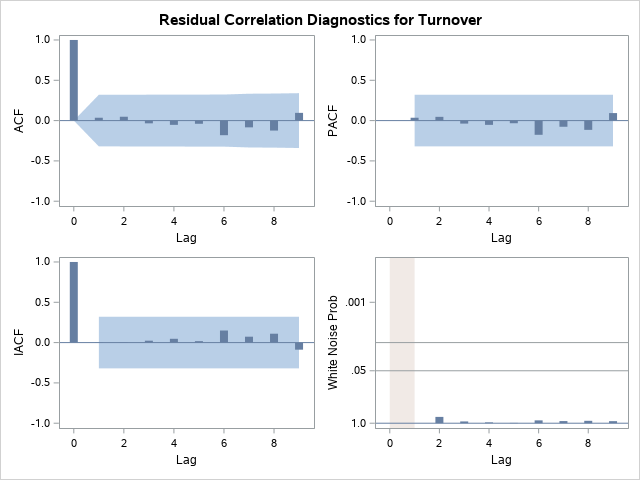
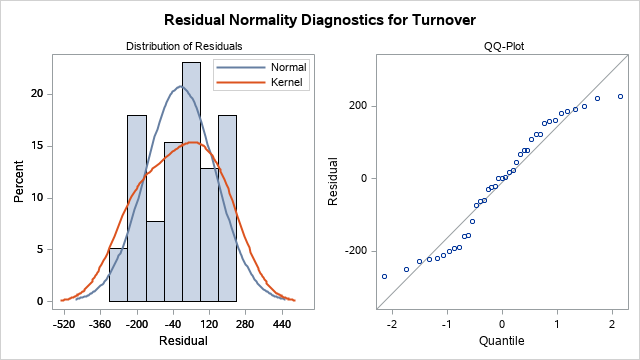
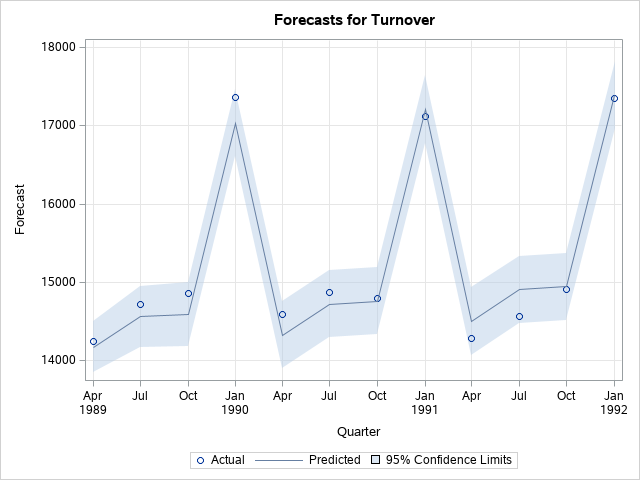

In [28]:
title2 "Regression Model (Attempt 2)";

proc arima data=retail;
    identify var=Turnover crosscorr=(Quarter Q1 Q2 Q3);
    estimate p=(1) input=(Quarter Q1 Q2 Q3);
    forecast back=12 lead=12 id=Quarter interval=qtr out=forecast1;
    ods select &arima_display;
    ods show;
run;

%rmse(forecast1);

After we add AR(1) to this model we don't see any more significant spikes in the autocorrelation plots for any of the lags.  We can also see that this model now passes the Ljung-Box white noise test.  We can now build an exponential smoothing model and see how it compares with this regression-based one.


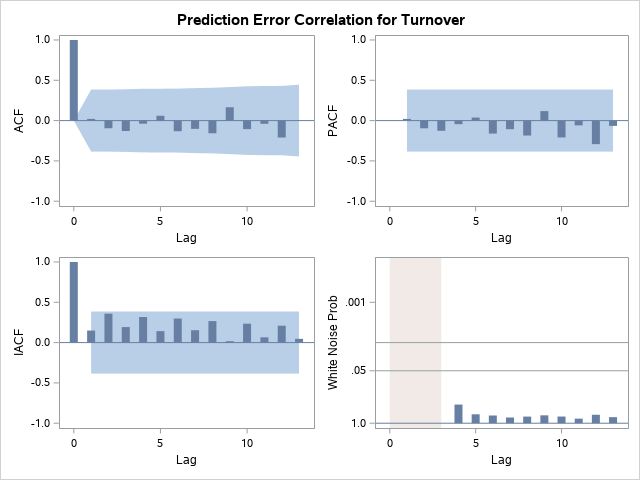
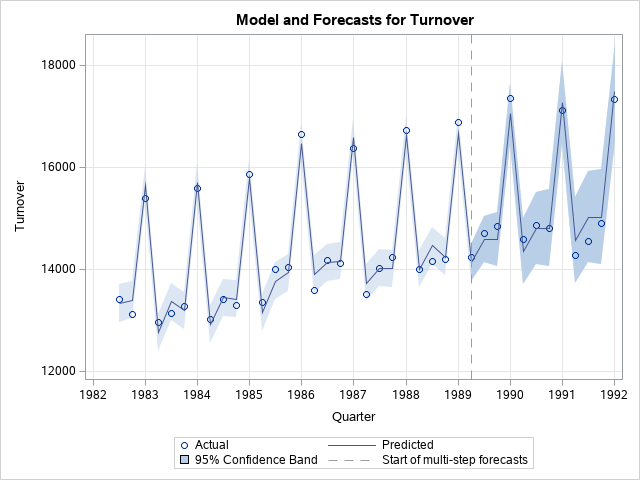

In [29]:
title2 "ESM Model";

proc esm data=retail seasonality=4 back=12 lead=12 outfor=forecast2 outstat=esm_stats
    plot=(corr modelforecasts) print=(estimates);
    id Quarter interval=qtr;
    forecast Turnover / model=addwinters;
    ods select ParameterEstimates ErrorCorrelationPlots ModelForecastsPlot;
    ods show;
run;

proc report data=esm_stats;
    column RMSE;
    where _REGION_='FORECAST';
    define RMSE / display format=9.4;
run;

In this triple exponential smoothing method (Holt-Winters additive method) we use a smoothing constant ($\alpha$) that allows us to give more weight to the most recent observations.  The weight declines exponentially as time passes so older observations will successively be given lower weights.  $\alpha$ is a number between 0 and 1.  The larger $\alpha$ is the more our predicted value will depend on the more current values and vice versa.  Beta ($\beta$) and Gamma ($\gamma$) are other smoothing constants used in the forecast and are also between 0 and 1.  $\alpha$ is the smoothing constant for the level of our series, $\beta$ is the smoothing constant for the trend of our series, and $\gamma$ is the smoothing constant of the seasonal factors.  $\alpha$, $\beta$, and $\gamma$ are typically selected to minimize the SSE of the errors.  In the output we see that SAS has estimated  $\alpha$ = 0.73966, $\beta$ = 0.0010, and $\gamma$ = 0.0010.  The standard equation for this model can be found [here](http://support.sas.com/documentation/cdl/en/etsug/67525/HTML/default/viewer.htm#etsug_tffordet_sect021.htm).

In the output we don't see any significant lags in the autocorrelation plots.  This model also passes the white noise test so we can say that the autocorrelation for the plots have been dealt with.  In the forecast plot we can see the prediction interval for the predicted value gradually widening as time goes on which is to be expected.  The model becomes less accurate as time passes.  

Next, we look at an ARIMA model.



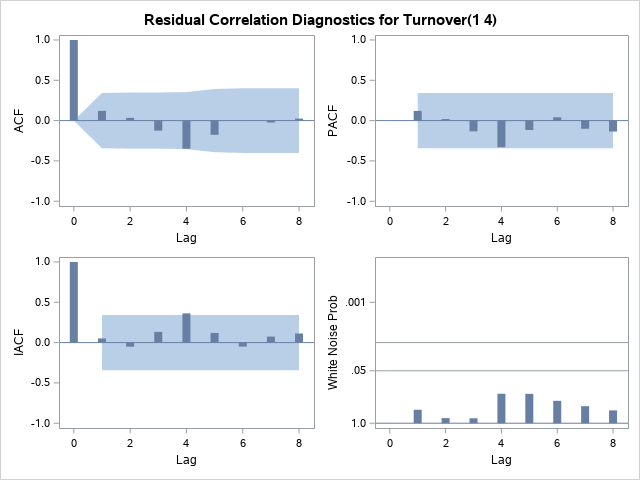
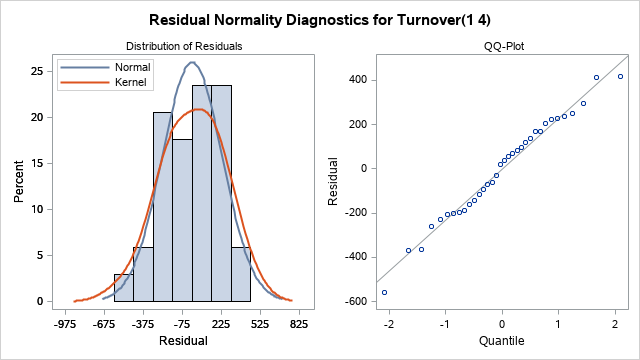
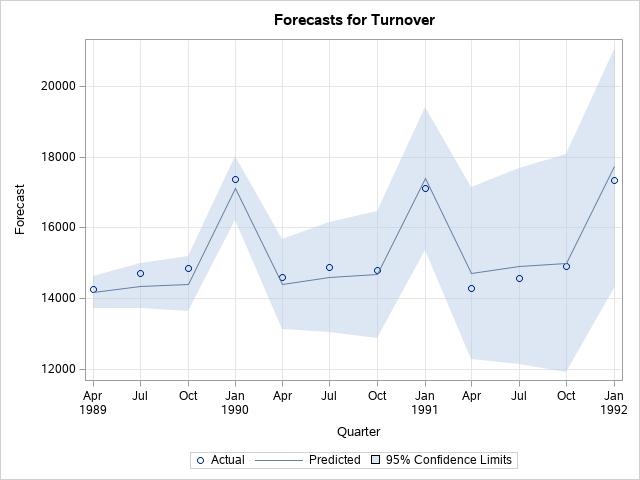

In [30]:
title2 "ARIMA Model (Attempt 1)";

proc arima data=retail;
    identify var=Turnover(1, 4);
    estimate;
    forecast back=12 lead=12 id=Quarter interval=qtr out=forecast3;
    ods select &arima_display;
    ods show;
run;

%rmse(forecast3);

In this Autoregressive integrated Moving Average (ARIMA) model we use differencing instead of trend and seasonal components/dummy variables.  We use differencing to transform our data from a nonstationary time series (non-constant mean or variance) to a stationary series.  In this time series we take a first difference and a fourth difference to account for the linear trend and seasonal pattern.  In the ACF and PACF plots we can see that the bar at lag 4 is significant so we can include an MA(4) to try to capture the autocorrelation.  We can also remove the intercept since it doesn't seem to be significant here.


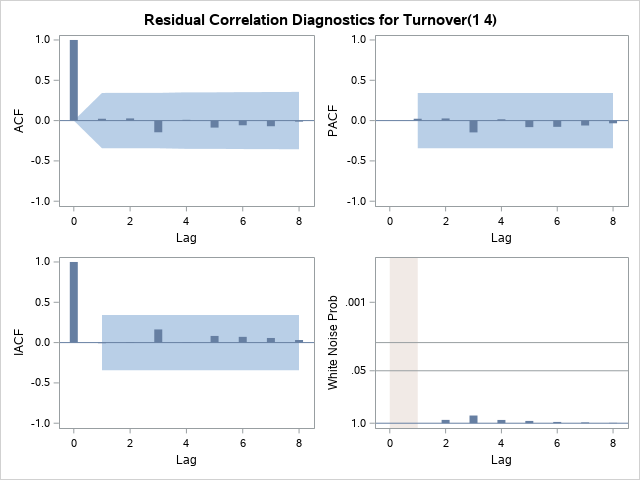
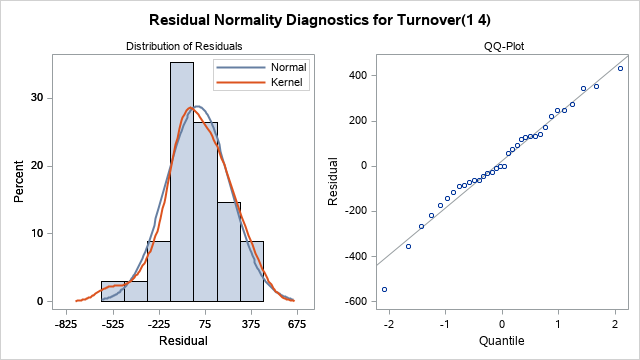
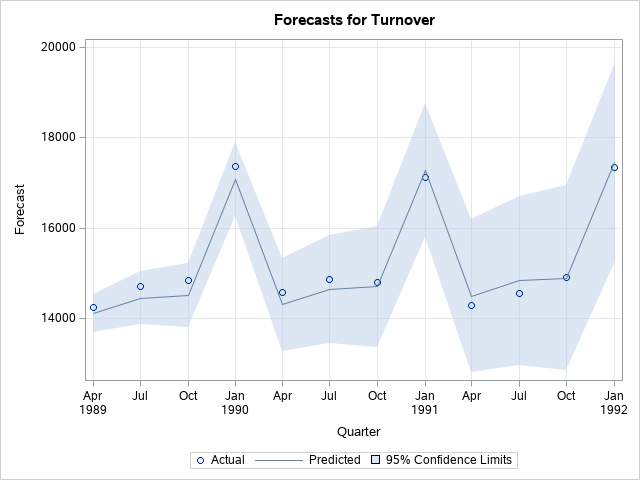

In [31]:
title2 "ARIMA Model (Attempt 2)";

proc arima data=retail;
    identify var=Turnover(1 4);
    estimate q=(4) noint;
    forecast back=12 lead=12 id=Quarter interval=qtr out=forecast4;
    ods select &arima_display;
    ods show;
run;

%rmse(forecast4);

In the autocorrelation function plots, we see that there are no significant lags.  We can also see that this model passes the white noise test.  Just like the ESM model, the prediction interval of the forecasted value continues to widen as move towards our holdout data because this model also becomes less precise as time passes.  We also managed to reduce the RMSE significantly (~297 to ~220).

Next, we move to compare the three models and see which performed best.



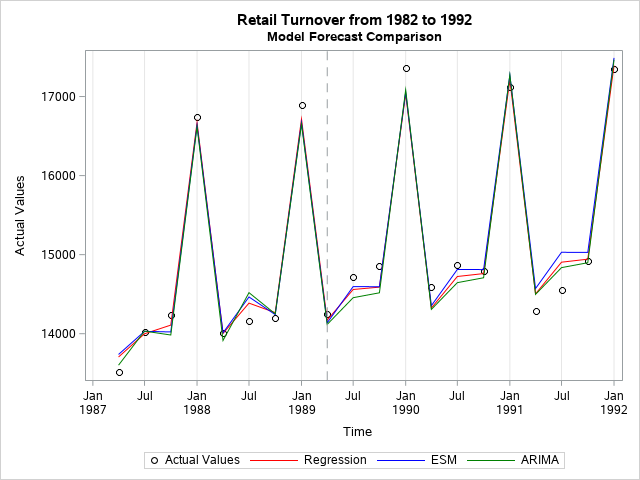

In [32]:
title2 "Model Forecast Comparison";

data forecast;
    set forecast1;
    Time=Quarter;
    Regression=forecast;
    format Time yyq6.;
    
    set forecast2;
    Actual=actual;
    ESM=predict;
    
    set forecast4;
    ARIMA=forecast;

    keep Time Actual Regression ESM ARIMA;
run;


proc sgplot data=forecast (firstobs=20);
    scatter x=Time y=Actual/ markerattrs=(color=Black);
    series x=Time y=Regression/ lineattrs=(color=Red);
    series x=Time y=ESM/ lineattrs=(color=Blue);
    series x=Time y=ARIMA/ lineattrs=(color=Green);
    refline "01Apr1989"d /axis=x lineattrs=(pattern=dash);
    xaxis grid;
run;

### Discussion
---

By eyeing the plot, it isn't immediately obvious which model performed best.  The RMSE for the holdout samples of each of the different fitted models were determined to be:

  * *Regression* - 200.4712

  * *ESM* - 225.5307

  * *ARIMA* - 219.5388

It seems that the ESM method performed the worst of the three judging by its RMSE.  We can also see that in the plot above, it seems to consistently be the furthest from the actual values.  In the time series regression model, we found that all of the coefficients where significant besides Q3.  In the ARIMA model we see that the only coefficient, MA(4) is significant.  We also see how the residuals in the ARIMA model is more normally distributed around a mean then the regression model.  Despite the fact that the Regression model gave us a lower RMSE, I would say that the ARIMA model performed better.  
